# Gas Lift Design (Valve Spacing)
**Objective:** Calculate the depths for Gas Lift Valves to unload a well.

**Author:** Ade Anggi Naluriawan Santoso

**The Challenge:**
When a well is "dead" (filled with heavy kill fluid), the reservoir pressure is too weak to push that heavy column to the surface. We cannot just inject gas at the bottom immediately because our compressor doesn't have enough pressure to overcome the full hydrostatic weight of the liquid column.

**The Solution (Unloading):**
We install a series of valves up the tubing.
1.  **Valve 1 (Top):** We inject gas here first to lift the top section of liquid.
2.  **Valve 2:** Once the top section is lighter, the pressure drops, allowing us to push gas deeper to Valve 2.
3.  **Repeated:** We "stair-step" our way down until we reach the bottom operating valve.

In this notebook, we will implement the standard **IPO (Injection Pressure Operated)** valve spacing design.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Design Parameters
We need to define the pressures available at the surface and the gradients of the fluids.

* **Kick-off Pressure ($P_{ko}$):** Max pressure available to start the well (e.g., 1000 psi).
* **Operating Pressure ($P_{so}$):** Normal operating injection pressure (usually lower than $P_{ko}$).
* **Kill Fluid Gradient ($G_s$):** The heavy fluid currently in the well (e.g., Brine 0.465 psi/ft).
* **Gas Gradient ($G_g$):** The weight of the gas column (e.g., 0.02 psi/ft).
* **Flowing Gradient ($G_f$):** The gradient of the aerated mixture we aim to achieve (e.g., 0.15 psi/ft).

In [2]:
# --- WELL PARAMETERS ---
p_kickoff = 1000   # Surface Kick-off Pressure (psia)
p_surf_op = 900    # Surface Operating Pressure (psia)
p_wh      = 100    # Wellhead Production Pressure (psia)

# Gradients (psi/ft)
grad_kill = 0.465  # Static Kill Fluid (e.g., 9.0 ppg brine)
grad_gas  = 0.025  # Injection Gas
grad_flow = 0.15   # Target Flowing Gradient (after lift)

depth_well = 8000  # Total Depth (ft)

# Design constraints
safety_drop = 50   # Pressure drop across valve to ensure closure (psi)

## 2. Valve Spacing Algorithm
The graphical design method involves plotting pressure lines and finding intersections. We will solve this mathematically.

**Step 1: Valve 1 Depth ($D_1$)**
Find the depth where the Kick-off Gas Pressure equals the Kill Fluid Pressure (minus safety margin).
$$P_{ko} + G_g D_1 = P_{wh} + G_s D_1 + Safety$$
$$D_1 = \frac{P_{ko} - P_{wh} - Safety}{G_s - G_g}$$

**Step 2: Subsequent Valves ($D_n$)**
The subsequent valves are spaced based on the *Flowing Gradient* ($G_f$). We proceed down the hole, ensuring that when we lift from Valve $n$, we reduce the tubing pressure enough to open Valve $n+1$.

In [3]:
def calculate_valve_spacing(p_ko, p_op, p_wh, g_kill, g_gas, g_flow, safety, max_depth):
    """
    Calculates depth of IPO valves.
    """
    valves = []
    
    # --- VALVE 1 CALCULATION ---
    # Balance: P_injection = P_tubing_kill
    # (P_ko) + (g_gas * D1) = (P_wh) + (g_kill * D1) + safety_margin?? 
    # Actually, usually P_tubing at D1 must be P_ko - safety to allow gas in.
    
    # Standard Formula: D1 = (P_ko - P_wh) / (g_kill - g_gas)
    # Note: Safety margin is usually applied to the P_ko line or the transfer point.
    
    # Using the equation: P_inj_at_depth = P_tubing_at_depth + Safety
    # P_ko + g_gas*D1 = P_wh + g_kill*D1
    # D1 * (g_kill - g_gas) = P_ko - P_wh
    
    d1 = (p_ko - p_wh) / (g_kill - g_gas)
    
    if d1 > max_depth:
        d1 = max_depth
        
    p_inj_d1 = p_ko + g_gas * d1
    p_tub_d1 = p_wh + g_kill * d1
    
    valves.append({
        'Valve': 1,
        'Depth': d1,
        'P_inj': p_inj_d1,
        'P_tub': p_tub_d1
    })
    
    # --- SUBSEQUENT VALVES ---
    # Now we switch to Operating Pressure (P_op) and Flowing Gradient (g_flow)
    # Logic: From the previous valve, we follow the Flowing Gradient line DOWN
    # until it intersects the Injection Pressure line.
    
    current_depth = d1
    valve_count = 1
    
    while current_depth < max_depth:
        prev_valve = valves[-1]
        
        # Determine Pressure at previous valve depth using Surface Operating Pressure line
        # Note: Usually design curves pivot off the Kickoff line for spacing, but simpler logic here:
        
        # 1. Injection Pressure Line: P_inj(D) = P_op + g_gas * D
        # 2. Tubing Pressure Line starting from Prev Valve:
        #    P_tub(D) = P_tub_at_prev + g_flow * (D - D_prev)
        
        # Intersection:
        # P_op + g_gas*D = P_tub_prev + g_flow*D - g_flow*D_prev
        # D(g_flow - g_gas) = P_op - P_tub_prev + g_flow*D_prev
        
        # P_tub_prev is the pressure in tubing at prev_depth while lifting from prev_depth.
        # This is roughly the Injection pressure at prev_depth minus differential.
        p_tub_prev_lifting = (p_op + g_gas * prev_valve['Depth']) - safety
        
        numerator = p_op - p_tub_prev_lifting + (g_flow * prev_valve['Depth'])
        denominator = g_flow - g_gas
        
        next_depth = numerator / denominator
        
        # If the step is too small or exceeds max depth, stop
        if next_depth > max_depth:
            # Place one final valve at bottom or stop
            break
            
        if (next_depth - current_depth) < 200: # Minimum spacing check
            break
            
        valve_count += 1
        p_inj_new = p_op + g_gas * next_depth
        p_tub_new = p_tub_prev_lifting + g_flow * (next_depth - current_depth)
        
        valves.append({
            'Valve': valve_count,
            'Depth': next_depth,
            'P_inj': p_inj_new,
            'P_tub': p_tub_new
        })
        
        current_depth = next_depth
        
    return pd.DataFrame(valves)

# Run the Design
design_df = calculate_valve_spacing(
    p_kickoff, p_surf_op, p_wh, 
    grad_kill, grad_gas, grad_flow, 
    safety_drop, depth_well
)

print("--- Gas Lift Valve Schedule ---")
print(design_df)

--- Gas Lift Valve Schedule ---
    Valve        Depth        P_inj        P_tub
0       1  2045.454545  1051.136364  1051.136364
1       2  2445.454545   961.136364   961.136364
2       3  2845.454545   971.136364   971.136364
3       4  3245.454545   981.136364   981.136364
4       5  3645.454545   991.136364   991.136364
5       6  4045.454545  1001.136364  1001.136364
6       7  4445.454545  1011.136364  1011.136364
7       8  4845.454545  1021.136364  1021.136364
8       9  5245.454545  1031.136364  1031.136364
9      10  5645.454545  1041.136364  1041.136364
10     11  6045.454545  1051.136364  1051.136364
11     12  6445.454545  1061.136364  1061.136364
12     13  6845.454545  1071.136364  1071.136364
13     14  7245.454545  1081.136364  1081.136364
14     15  7645.454545  1091.136364  1091.136364


## 3. Visualization (The Graphical Design)
The best way to understand spacing is to plot the traverse lines.

1.  **Kill Line (Blue):** The pressure of the heavy fluid.
2.  **Kick-off Gas Line (Red):** The max gas pressure available.
3.  **Operating Gas Line (Red Dashed):** The normal gas pressure.
4.  **Flowing Gradient (Green):** The target pressure profile.
5.  **Valves (Black Dots):** The intersection points.

**Interpretation:**
Notice how the valves get closer together as we go deeper?
This is because the differential between the Gas Pressure (Input) and Flowing Pressure (Required) gets smaller at depth.

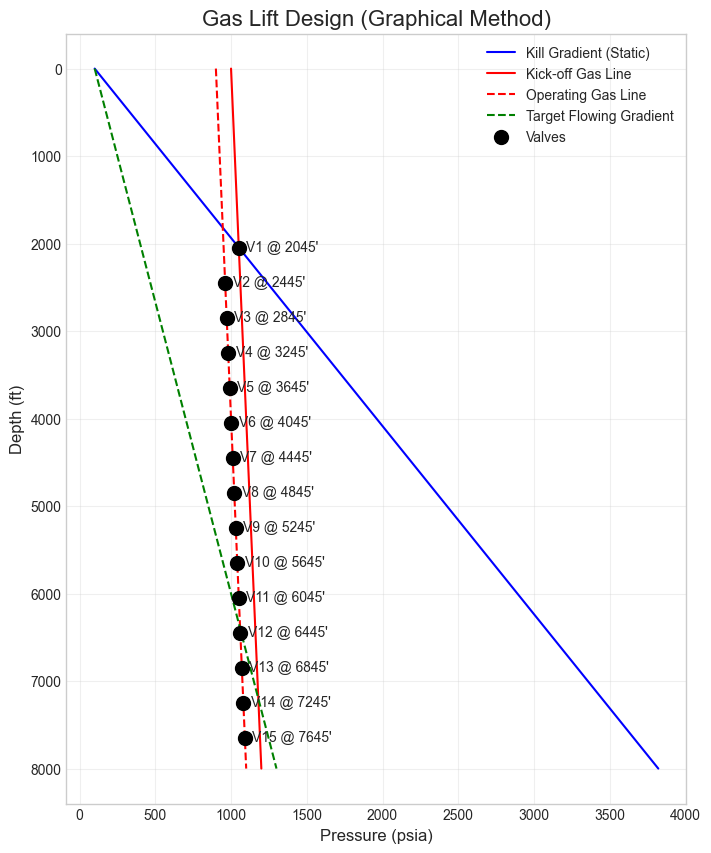

In [4]:
plt.figure(figsize=(8, 10))

# Depth range
depths = np.linspace(0, depth_well, 100)

# 1. Plot Pressure Traverses
# Kill Fluid Line (P_wh + G_kill * D)
plt.plot(p_wh + grad_kill * depths, depths, 'b-', label='Kill Gradient (Static)')

# Kick-off Gas Line (P_ko + G_gas * D)
plt.plot(p_kickoff + grad_gas * depths, depths, 'r-', label='Kick-off Gas Line')

# Operating Gas Line (P_op + G_gas * D)
plt.plot(p_surf_op + grad_gas * depths, depths, 'r--', label='Operating Gas Line')

# Flowing Gradient (approximate line from P_wh)
plt.plot(p_wh + grad_flow * depths, depths, 'g--', label='Target Flowing Gradient')

# 2. Plot Valves
plt.scatter(design_df['P_inj'], design_df['Depth'], color='black', s=100, zorder=10, label='Valves')

# Annotate Valves
for index, row in design_df.iterrows():
    plt.text(row['P_inj'] + 50, row['Depth'], f"V{int(row['Valve'])} @ {int(row['Depth'])}'", 
             verticalalignment='center')

# Formatting
plt.gca().invert_yaxis() # Depth increases downwards
plt.title("Gas Lift Design (Graphical Method)", fontsize=16)
plt.xlabel("Pressure (psia)", fontsize=12)
plt.ylabel("Depth (ft)", fontsize=12)
plt.grid(True, which='both', alpha=0.3)
plt.legend(loc='upper right')

plt.show()

## Summary
You have designed a 5-6 valve string (depending on your params).

**How it works in practice:**
1.  Compressor pressurizes casing to 1000 psi ($P_{ko}$).
2.  Gas enters **Valve 1** at ~2000 ft. Liquid above it lightens and flows out.
3.  Casing pressure drops to 900 psi ($P_{op}$).
4.  Liquid level drops, uncovering **Valve 2**.
5.  Gas enters Valve 2. The pressure at Valve 1 drops, causing Valve 1 to close.
6.  Process repeats until lifting from the bottom valve.